# Comparison of Various Machine Learning Models within the MICE Framework

Michael Rowlands 

August 2023


## Summary


### Background
Imputation, the process of filling in missing values within a dataset, is a critical step in data preprocessing, especially when dealing with real-world data where missing values are common. 

Multiple Imputation by Chained Equations (MICE) is a powerful imputation technique that unfortunately sees infrequent usage in machine learning primarialy due to a percieved lack of need for the rigor of multiple imputation, and due to the computation expense required to perform it. This has lead to a blind spot in the development of a MICE imputer which can handle categorical data as well as numeric data (see the scikit learn documentation on their iterative imputer https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html). 

### Objective
The primary objective of this analysis was to compare various imputation techniques on a downstream machine learning task using activity data from a Strava account. 

### Methodology
The analysis began with data exploration and preprocessing. Several imputation methods were applied, including MICE, and the results were compared using the error associated with different predictive models on predicting elasped time for an activity. 


### Findings
The study revealed differences in the effectiveness of imputation methods across different types of data. The insights derived from the analysis provide valuable guidance for handling missing data in similar contexts. In particular, we find that models which are more robust to outliers and allow for regularization performed well in this context. By using the multiple imputation framework we are able to conduct analyses which are more accurate with respect to model estimates and error. 


## Package and Data Import

We begin by importing the relevant packages and data for this project. 

In [1]:
import os
import sys
sys.path.append("../")

from Scripts.imputation import *
from Scripts.inputs import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from collections import Counter

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../Data/activities.csv", delimiter=',', usecols=features)


## Data Exploration

The dataset used in this analysis comes from Strava, a popular platform for tracking physical activities such as running and biking. It includes a variety of features related to sport, location, distance, elevation, temperature, and more. Understanding the nature of this data and the patterns of missingness is crucial for effective imputation. It should be noted that an assumption of MICE is that the data is MCAR. In this setting we believe this to be satisfied. 

### Exploring Data Types and Missingness
The first step is to explore the data types within the dataset and identify the presence and patterns of missing values. This will inform the choice of imputation methods and provide insight into the nature of the data.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Activity Type            1137 non-null   object 
 1   Elapsed Time             1137 non-null   int64  
 2   Distance                 1137 non-null   float64
 3   Elevation Gain           915 non-null    float64
 4   Elevation Loss           862 non-null    float64
 5   Elevation Low            853 non-null    float64
 6   Elevation High           853 non-null    float64
 7   Average Grade            1137 non-null   float64
 8   Average Temperature      455 non-null    float64
 9   Grade Adjusted Distance  787 non-null    float64
 10  Dirt Distance            1137 non-null   float64
 11  Total Steps              107 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 106.7+ KB


### Introducing Missing Data
We see that there are various data types and amounts of missing data within the dataset. In this analysis, we artificially removed some data from the 'Activity Type' column to create a more challenging imputation scenario. This allows us to test how different imputation methods perform with both missing categorical and numerical data.

In [15]:
# Set a random seed for reproducibility
np.random.seed(42)

# Make a copy of the original data before introducing artificial missingness
df_original = df.copy()

# Introduce artificial missingness in 'Activity Type' column
missingness_mask = np.random.choice([True, False], size=df.shape[0], p=[0.3, 0.7]) # 30% missingness
df.loc[missingness_mask, 'Activity Type'] = np.nan

# Check for missing values in 'Activity Type' column
missing_values_artificial = df['Activity Type'].isnull().sum()

print(missing_values_artificial)


362


### Splitting Data
The dataset is split into features and target, with 'Elapsed Time' as the target variable. The data is further divided into training and testing sets, with 20% of the data reserved for testing. This ensures a fair evaluation of the models and imputation methods used.

In [6]:
df_to_impute = df.copy()

X = df_to_impute.drop("Elapsed Time", axis=1)

y = np.log(df_to_impute['Elapsed Time'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


## Data Visualization

Visualizing the distributions of numerical features and the relationships between different attributes will help in understanding the underlying structure of the data. This exploration guides the preprocessing and modeling steps that follow.

### Pairplot of Selected Features
A pairplot is used to visualize the relationships between selected numerical features, such as 'Distance,' 'Elevation Gain,' and others. It provides insights into the correlations and potential trends between these variables.


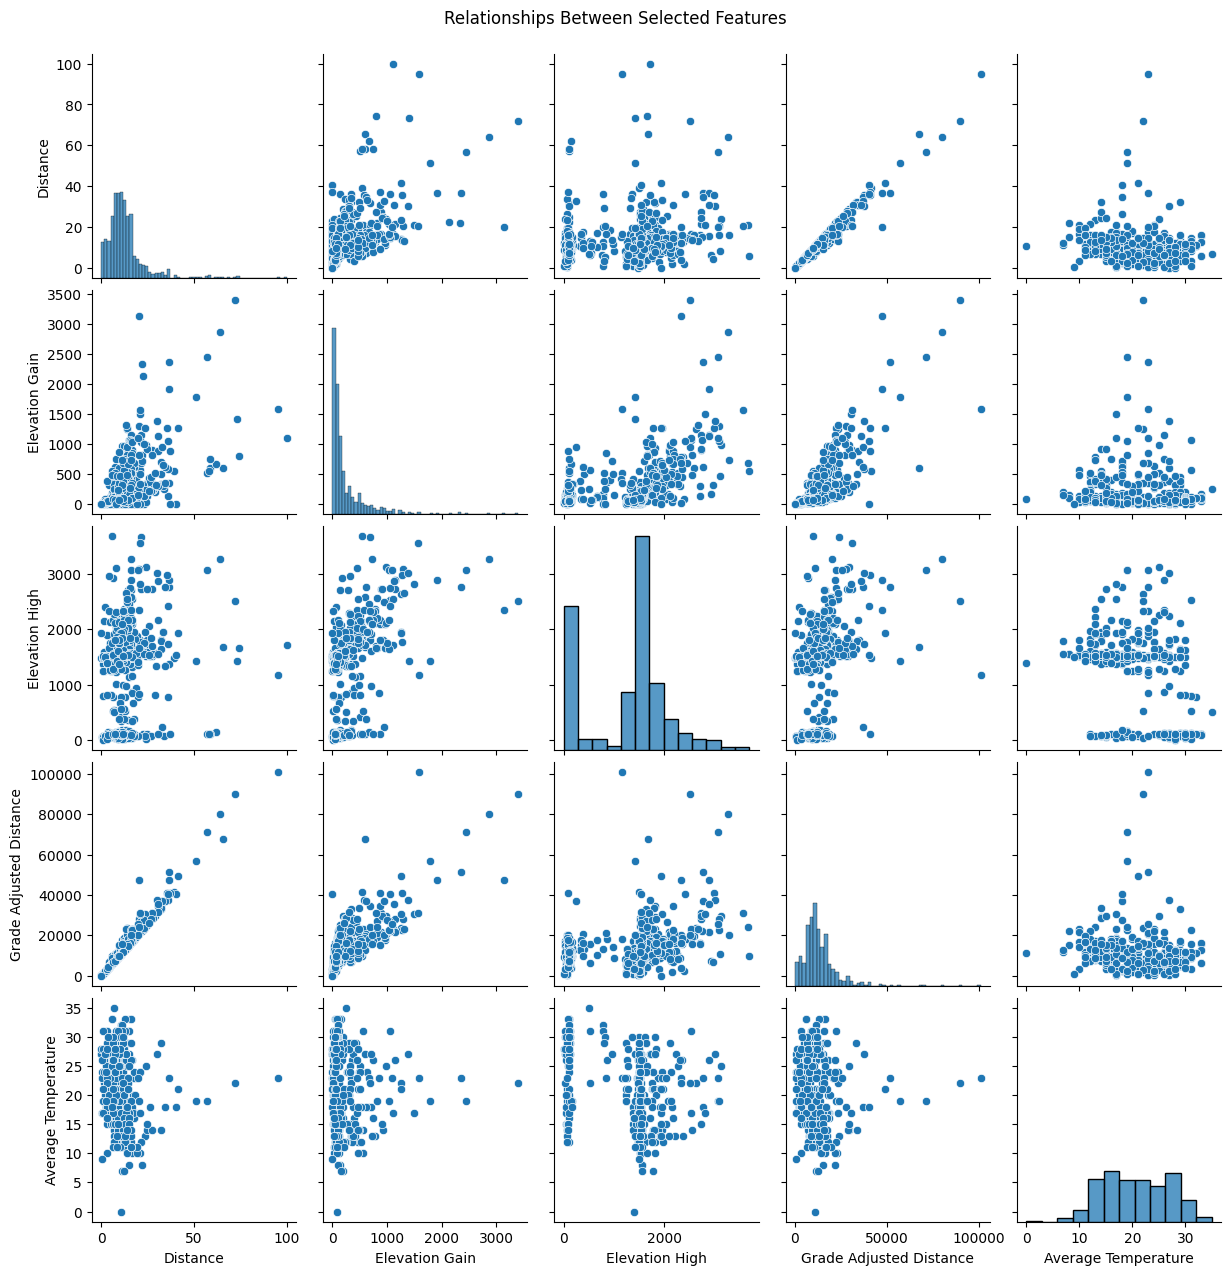

In [7]:
cat_cols = ['Activity Type']
num_cols = [col for col in X_train.columns if col not in cat_cols]
plot_cols = ['Distance', 'Elevation Gain', 'Elevation High', 'Grade Adjusted Distance', 'Average Temperature']
pairplot = sns.pairplot(X_train[plot_cols])
pairplot.fig.suptitle('Relationships Between Selected Features', y=1.02)
plt.show()

We see a variety of relationships among the different variables, but there seems to be some heavy correlation between some of the variables indicating that either some feature engineering or models with heavy regularization is in order. Also, elevation gain likely needs a log transform to be more normally distributed; this gives us an indication that elapsed time likely needs one too. 

### Heatmap of Correlations
A heatmap is utilized to show the correlations between features. This helps in understanding how different variables are related to each other, which can inform feature selection and modeling decisions.


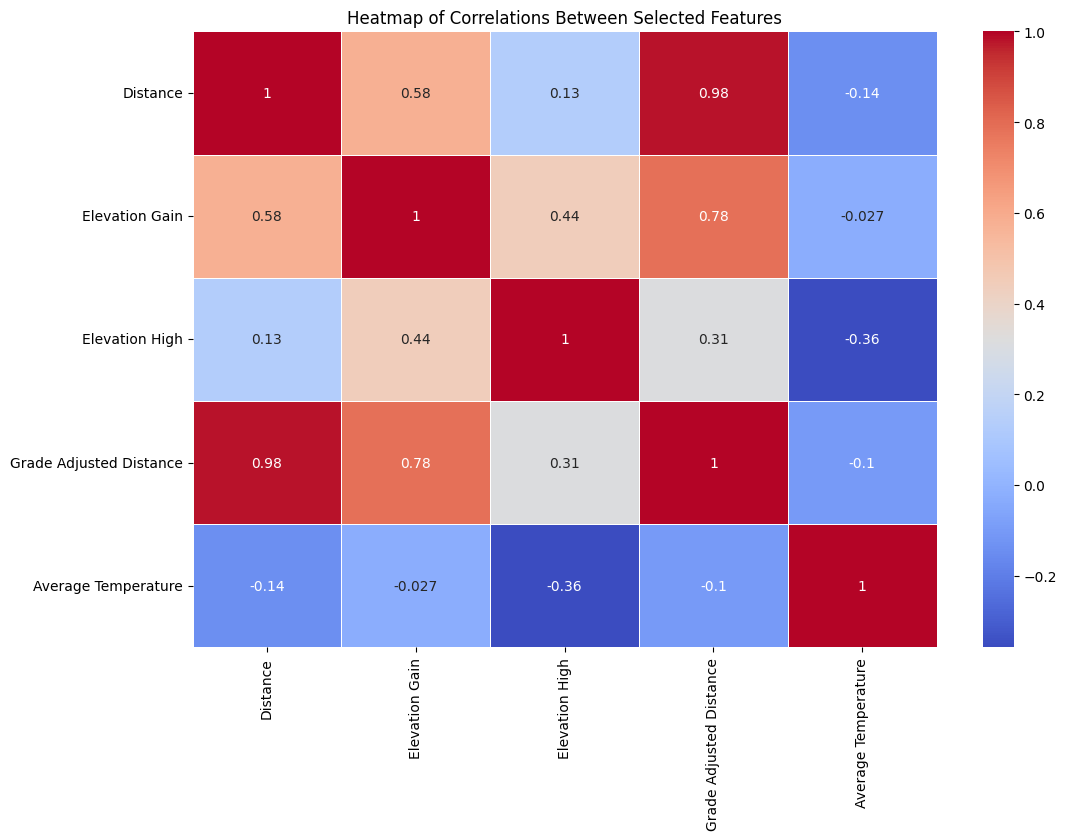

In [8]:
corr_matrix = X_train[plot_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Correlations Between Selected Features')
plt.show()

As we expected, there are variables that are strongly correlated with one another. We are going to choose to ignore this issue for now, and see how various models impute the data given this colinearity. 

### Boxplots of Activity Type vs. Distance
Using subject matter knowledge to inform modeling is important in any ML project. In this case, distance is likely going to be the most important variable along with activity type in terms of prediction of elapsed time. Boxplots are used to visualize the distribution of distances for different activity types. This aids in understanding how different activities correspond to varying distances, both before and after imputation.


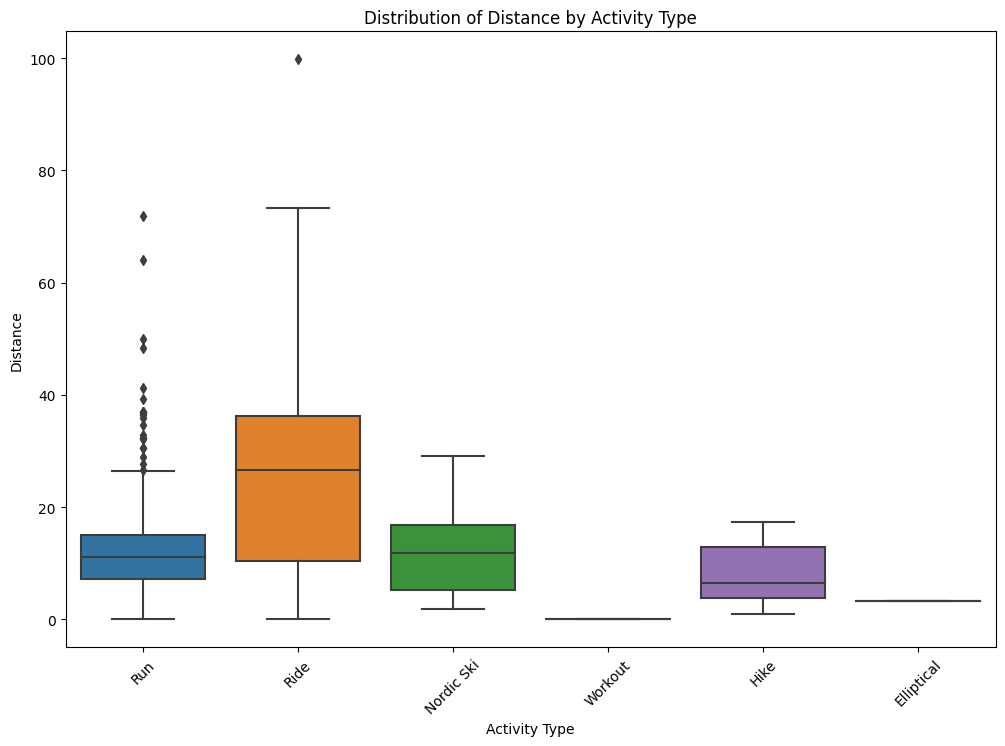

In [14]:

plt.figure(figsize=(12, 8))
sns.boxplot(x='Activity Type', y='Distance', data=X_train)
plt.title('Distribution of Distance by Activity Type')
plt.xlabel('Activity Type')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.show()


We see that there are different distributions for the various activities, but there still is some overlap that the imputation models might not be able to distinguish depending on how important the find the distance feature. 

## Modeling and Imputation

The core of this analysis lies in the application and comparison of different imputation methods. Imputation is the process of filling in missing values in a dataset, and the choice of method can significantly impact the quality of the data and the resulting models. 


### Multiple Imputation by Chained Equations (MICE)
MICE is a versatile imputation method that creates multiple imputations by using chained equations. It was applied to the missing values in both categorical and numerical data, and its results were compared with other methods.

We begin by showing how the framework works with only Linear and Logistic Regression as the imputation models for the numeric and categorical columns, and then will move on to a broad comparison. 

In [11]:
imputation_models = {}

for col in X_train.columns:
    if col in cat_cols:
        imputation_models[col] = LogisticRegression(solver='liblinear')
    else:
        imputation_models[col] = LinearRegression()

imputed_dfs = multiple_imputations(X_train, X_test, numerical_vars=num_cols, imputation_models= imputation_models, num_imputations=3, noise_factor=.8)

### Post Imputation Visualization

We now have three imputed datasets to work with. Let's begin by visualizing the post imputation correlation heatmap and distance by activity type boxplots. 

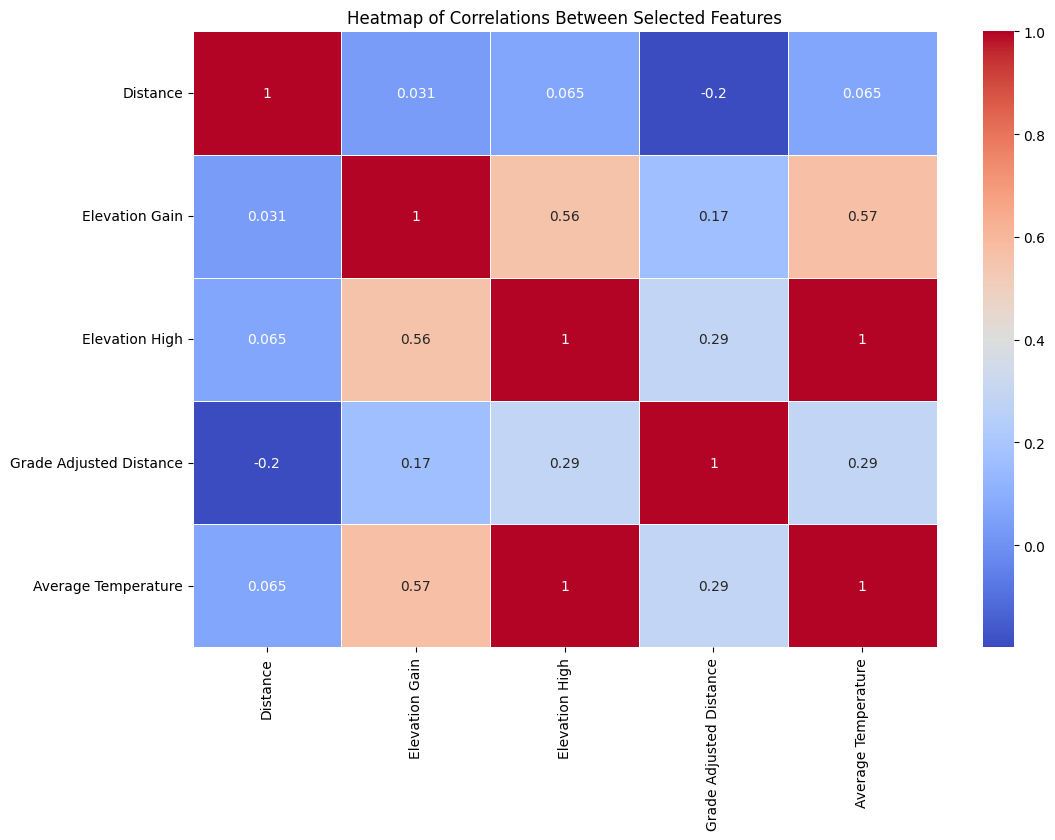

In [12]:
corr_matrix = imputed_dfs['Imputation_1']['Train'][plot_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Correlations Between Selected Features')
plt.show()

We see that the imputation changed many of the relationships between the features in the first dataset. Notably, the elevation high column and average temperature are now perfectly correlated. Also, the elevation gain and distance columns became very uncorrelated. This might be because the imputation models are not well suited for this dataset since there are still many colinearities in the feature space. 

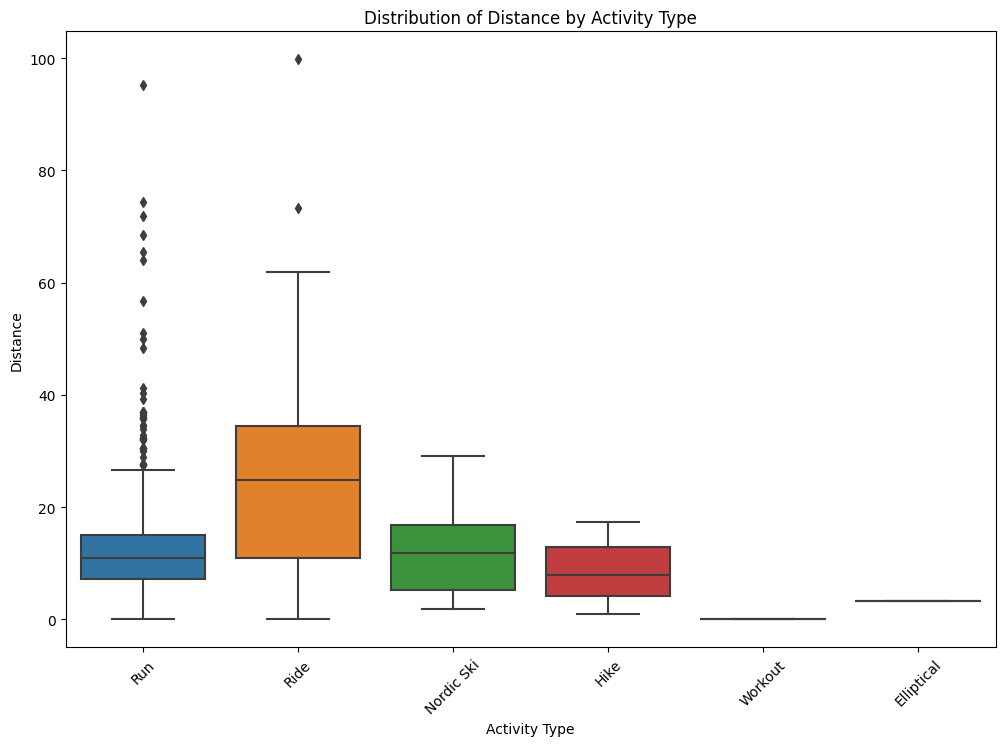

In [13]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Activity Type', y='Distance', data=imputed_dfs['Imputation_1']['Train'])
plt.title('Distribution of Distance by Activity Type')
plt.xlabel('Activity Type')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.show()




### Predictive Modeling
Different predictive models, including Linear Regression, Random Forests, Gradient Boosting, and SVM were used to evaluate the performance of the imputation methods. A hyperparameter tuning step is added to allow for the models to perform as well as possible. This provides a comprehensive view of how the imputed data performs in various modeling scenarios. 

We will be scoring the models with RMSE as the metric for ease of interpretation and applicability to the problem at hand. For an exact look at the workflow look to the imputation script which contains the two functions we are using here. A general outline is as follows:

1) Split the training data into 5 folds using each one as a validation set once.
2) For each validation set, preprocess and impute the remainder of the training set and validation set using a pipeline containing the preproccessing steps and the multiple_imputation function treating the validation set as the test set to prevent data leakage. 
3) Hyperparameter tune according to the defined grid and output the RMSE for the fold/imputation number.
4) Aggregate the scores and output the best parameters for further analysis. 


In [17]:
imputation_models = {}

for col in X_train.columns:
    if col in cat_cols:
        imputation_models[col] = LogisticRegression(solver='liblinear')
    else:
        imputation_models[col] = LinearRegression()

prediction_models = {'Lasso': Lasso(),
'Elastic Net': ElasticNet(),
'Random Forest': RandomForestRegressor(),
'Gradient Boosting': GradientBoostingRegressor(),
'SVM': SVR()}

hyperparams = {'Lasso': {'model__alpha': [.01, .1, .5, .75, 1]},
'Elastic Net': {'model__alpha': [.01, .1, .5, .75, 1]},
'Random Forest' : {'model__n_estimators': [1,10,100,1000],
'model__max_depth' : [None, 1,3,5,10]},
'Gradient Boosting' : {'model__n_estimators': [1,10,100,1000],
'model__subsample' : [.1,.25,.5,.75,1]},
"SVM" :  {'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
'model__gamma': ['scale', 'auto']}
}


base_scores, best_params = score(X_train, y_train, num_vars=num_cols, models=prediction_models,
imputation_models = imputation_models, scoring = 'neg_root_mean_squared_error', hyperparameters=hyperparams, num_imputations=2, rs_iter=3)

Now to see what the best parameters and scores for the SVM model are.

In [19]:
best_params['SVM']

{'best_params': [{'model__kernel': 'sigmoid', 'model__gamma': 'auto'},
  {'model__kernel': 'rbf', 'model__gamma': 'auto'},
  {'model__kernel': 'rbf', 'model__gamma': 'scale'},
  {'model__kernel': 'sigmoid', 'model__gamma': 'auto'},
  {'model__kernel': 'rbf', 'model__gamma': 'auto'},
  {'model__kernel': 'rbf', 'model__gamma': 'scale'},
  {'model__kernel': 'rbf', 'model__gamma': 'scale'},
  {'model__kernel': 'rbf', 'model__gamma': 'auto'},
  {'model__kernel': 'rbf', 'model__gamma': 'auto'},
  {'model__kernel': 'rbf', 'model__gamma': 'auto'}],
 'best_score': -1.4841345487154751,
 'best_score_std': 2.0886701698134136}

We see that the model had an average RMSE of 1.48(log seconds) across the 2 imputations and 5 folds.

### Comparison of Different Imputation Models

We now will compare various imputation models with the same workflow and visualize the results. 

In [20]:
cat_cols = ['Activity Type']

num_cols = [col for col in X_train.columns if col not in cat_cols]

imputation_methods = {
'Linear/Logistic': {
'num': LinearRegression(),
'cat': LogisticRegression(solver='liblinear')
},
'Random Forest': {
'num': RandomForestRegressor(),
'cat': RandomForestClassifier()
},
'Gradient Boosting':{
'num': GradientBoostingRegressor(),
'cat': GradientBoostingClassifier()
},
'SVM' : {
'num': SVR(),
'cat': SVC()
}
}

prediction_models = {'Lasso': Lasso(),
'Elastic Net': ElasticNet(),
'Random Forest': RandomForestRegressor(),
'Gradient Boosting': GradientBoostingRegressor(),
'SVM': SVR()}

hyperparams = {'Lasso': {'model__alpha': [.01, .1, .5, .75, 1]},
'Elastic Net': {'model__alpha': [.01, .1, .5, .75, 1]},
'Random Forest' : {'model__n_estimators': [1,10,100,1000],
'model__max_depth' : [None, 1,3,5,10]},
'Gradient Boosting' : {'model__n_estimators': [1,10,100,1000],
'model__subsample' : [.1,.25,.5,.75,1]},
"SVM" :  {'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
'model__gamma': ['scale', 'auto']}
}

In [24]:
results = {}

# Iterate through imputation methods
for method_name, imputation_method in imputation_methods.items():
# Create a dictionary for imputation models based on the method
    imputation_models = {}
    for col in X_train.columns:
        if col in cat_cols:
            imputation_models[col] = imputation_method['cat']
        else:
            imputation_models[col] = imputation_method['num']

    # Evaluate the prediction models using the score function
    base_scores, best_params = score(
    X_train, y_train,
    num_vars=num_cols,
    models=prediction_models,
    imputation_models=imputation_models,
    scoring='neg_root_mean_squared_error',
    hyperparameters=hyperparams,
    num_imputations=5,
    rs_iter=3
    )

    # Store the results for this imputation method
    results[method_name] = {
    'Base Scores': base_scores,
    'Best Parameters': best_params
    }



## Results


### Bar Plot of Prediction Models vs. RMSE
A bar plot is used to compare the Root Mean Square Error (RMSE) of different imputation methods across various prediction models. It provides an overview of how the imputed data performs in terms of accuracy and stability. The comparison reveals important differences in performance, helping to identify which methods are more robust and accurate in various predictive scenarios.


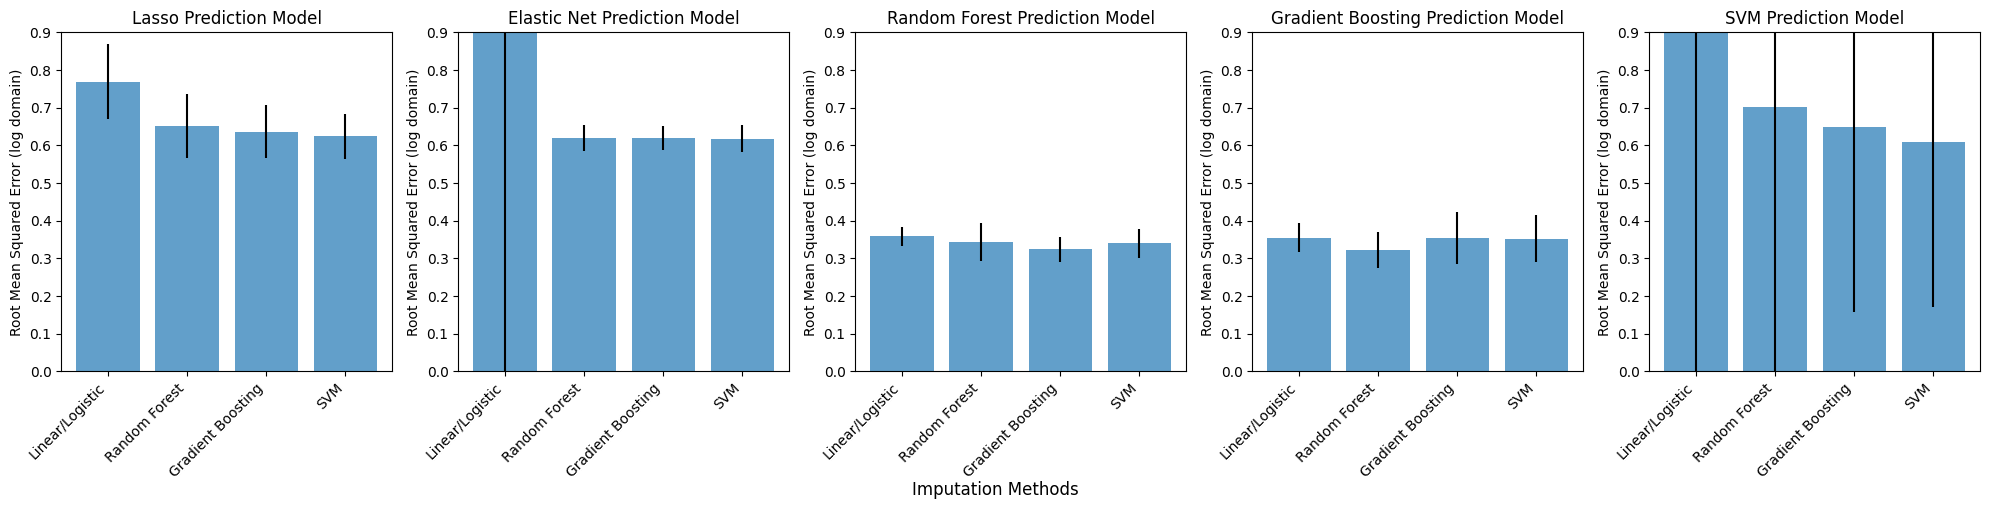

In [36]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(prediction_models), figsize=(20, 5))
prediction_models = list(results['Linear/Logistic']['Best Parameters'].keys())

# Iterate through prediction models
for i, prediction_model in enumerate(prediction_models):
    ax = axes[i]

# Scores and standard deviations for each imputation method
    scores = []
    std_devs = []
    imputation_methods = []

    for imputation_method, result in results.items():
        best_params = result['Best Parameters'][prediction_model]
        best_score = -best_params['best_score'] # Positive RMSE

# Filter out outliers
      
        scores.append(best_score)
        std_devs.append(best_params['best_score_std'])
        imputation_methods.append(imputation_method)

# Plot the results for this prediction model
    ax.bar(imputation_methods,scores, yerr=std_devs, alpha=0.7)
    ax.set_title(f"{prediction_model} Prediction Model")
    ax.set_ylabel('Root Mean Squared Error (log domain)')
    ax.set_ylim([0,.9])
    ax.set_xticklabels(imputation_methods, rotation=45, ha='right')

fig.text(0.5, 0.01, 'Imputation Methods', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()


We see that the Random Forest and Gradient Boosting prediction models perform the best across all of the imputation strategies, and that all of the imputation models apart from Linear/Logistic regression tend to perform at similar levels. 

To pick the best model we will construct a confidence interval for the mean cross-validation score, and then select the model with the least upper bound. 

In [28]:
# Confidence level for the z-score
confidence_level = 0.95
z_score = norm.ppf(1 - (1 - confidence_level) / 2)

best_upper_bound = float('inf')
best_imputation_method = None
best_prediction_model = None

# Iterate through imputation methods and prediction models
for imputation_method, result in results.items():
    for prediction_model, best_params in result['Best Parameters'].items():
        mean_score = -best_params['best_score'] # Positive RMSE
        std_dev = best_params['best_score_std']

        # Number of samples (imputations)
        n_samples = len(best_params['best_params'])

        # Calculate the standard error
        standard_error = std_dev / (n_samples ** 0.5)

        # Calculate the upper bound of the 95% CI
        upper_bound = mean_score + z_score * standard_error

        # Check if this combination has the lowest upper bound so far
        if upper_bound < best_upper_bound and mean_score < threshold:
            best_upper_bound = upper_bound
            best_imputation_method = imputation_method
            best_prediction_model = prediction_model

    best_hyperparameters = results[best_imputation_method]['Best Parameters'][best_prediction_model]['best_params']

print(f"Best Imputation Method: {best_imputation_method}")
print(f"Best Prediction Model: {best_prediction_model}")
print(f"Best Upper Bound of 95% CI: {best_upper_bound}")
print(f"Best Hyperparameters: {best_hyperparameters}")


Best Imputation Method: Gradient Boosting
Best Prediction Model: Random Forest
Best Upper Bound of 95% CI: 0.33720020856421
Best Hyperparameters: [{'model__n_estimators': 1000, 'model__max_depth': 10}, {'model__n_estimators': 1000, 'model__max_depth': None}, {'model__n_estimators': 1000, 'model__max_depth': 10}, {'model__n_estimators': 100, 'model__max_depth': 10}, {'model__n_estimators': 1000, 'model__max_depth': None}, {'model__n_estimators': 100, 'model__max_depth': 10}, {'model__n_estimators': 1000, 'model__max_depth': None}, {'model__n_estimators': 10, 'model__max_depth': None}, {'model__n_estimators': 100, 'model__max_depth': 10}, {'model__n_estimators': 100, 'model__max_depth': 5}, {'model__n_estimators': 100, 'model__max_depth': 5}, {'model__n_estimators': 10, 'model__max_depth': 5}, {'model__n_estimators': 100, 'model__max_depth': None}, {'model__n_estimators': 1, 'model__max_depth': 10}, {'model__n_estimators': 10, 'model__max_depth': 5}, {'model__n_estimators': 100, 'model__

We see that Gradient Boosting imputation along with random forest prediction is the best performing in this sense, so we will take this to be our final model. We need to select the best hyperparameter combination, and we will do this by picking the mode for both hyperparameters. After this we will retrain this model on the entire training set to use this model on the test set to estimate how well it would perform on unseen data. 

In [37]:
# Extract the values for each hyperparameter
max_depth_values = [params['model__max_depth'] for params in best_hyperparameters]
n_estimators_values = [params['model__n_estimators'] for params in best_hyperparameters]

# Find the mode for each hyperparameter
max_depth_mode = Counter(max_depth_values).most_common(1)[0][0]
#subsample_mode = Counter(subsample_values).most_common(1)[0][0]
n_estimators_mode = Counter(n_estimators_values).most_common(1)[0][0]

# Combine into the final set of hyperparameters
final_hyperparameters = {'model__max_depth': max_depth_mode, 'model__n_estimators': n_estimators_mode}

print(f"Final Hyperparameters: {final_hyperparameters}")


Final Hyperparameters: {'model__max_depth': 10, 'model__n_estimators': 100}


In [33]:
imputation_models = {}

for col in X_train.columns:
    if col in cat_cols:
        imputation_models[col] = GradientBoostingClassifier()
    else:
        imputation_models[col] = GradientBoostingRegressor()


gb_rf_df = multiple_imputations(train_data = X_train, test_data=X_test, numerical_vars=num_cols, imputation_models=imputation_models, num_imputations=1)

We now have a final dataset to work with. As a final sanity check, we will look at the correlations in the imputed dataset to see if it matches with expectations and the original dataset. 

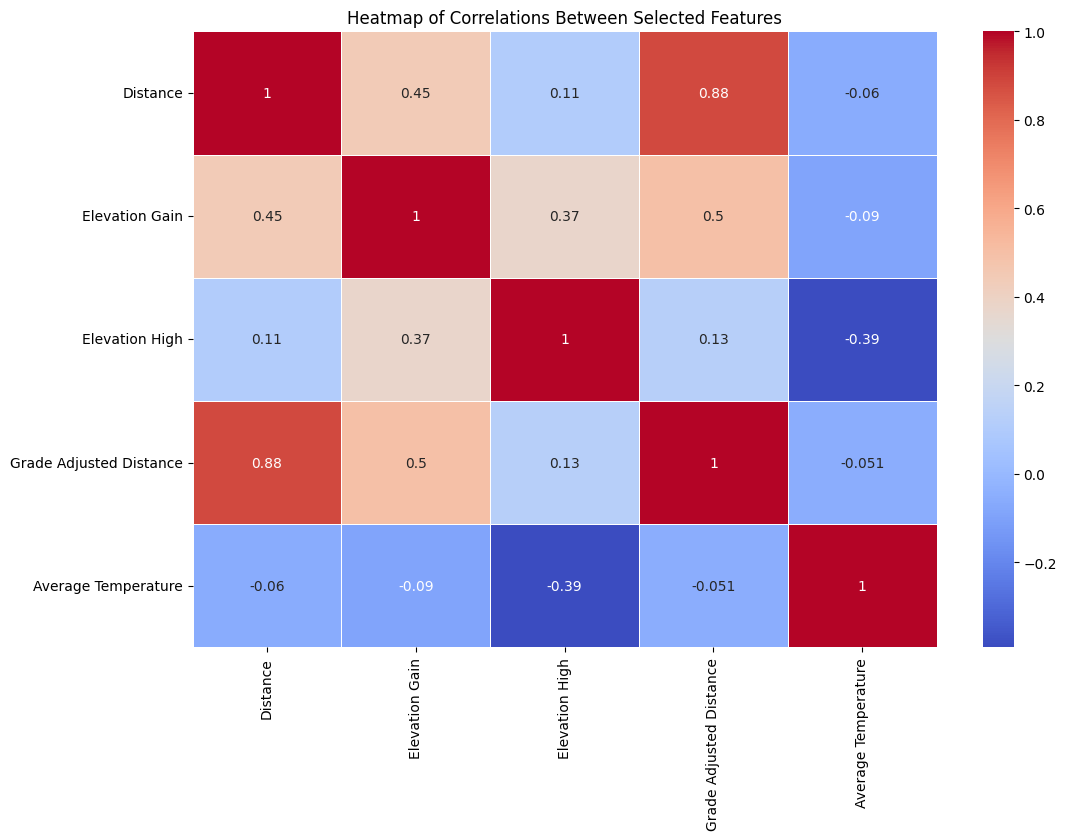

In [35]:
corr_matrix = gb_rf_df['Imputation_1']['Train'][plot_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Correlations Between Selected Features')
plt.show()

This agrees with expectations indicating that the gradient boosting models were more robust to the colinearity in the dataset.

We will now calculate our test scores. 

In [38]:
preprocessor = ColumnTransformer(
transformers=[
('num', StandardScaler(), num_cols),
('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
]
)

rf= RandomForestRegressor(max_depth=max_depth_mode, n_estimators=n_estimators_mode)

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
('model', rf)])


pipeline_rf.fit(gb_rf_df['Imputation_1']['Train'], y_train)

y_pred = pipeline_rf.predict(gb_rf_df['Imputation_1']['Test'])

final_rmse_log_domain = np.sqrt(mean_squared_error(y_test, y_pred))

final_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))

residuals = np.exp(y_test) - np.exp(y_pred)

residuals_log = y_test - y_pred


In [39]:
print('Final RMSE (log domain)',final_rmse_log_domain)
print('Final RMSE original domain:', final_rmse)

Final RMSE (log domain) 0.25218097283118784
Final RMSE original domain: 2197.088574402293


### Scatter Plots of the Residuals
We see that the scores on the test set are within expectations. We note that the score in the original domain is slightly larger than desired, but this is likely due to outliers and high leverage points. To explore this we will look at scatter plots of the residuals.

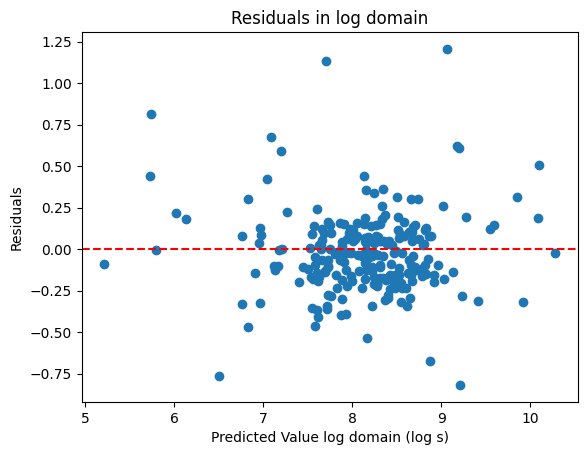

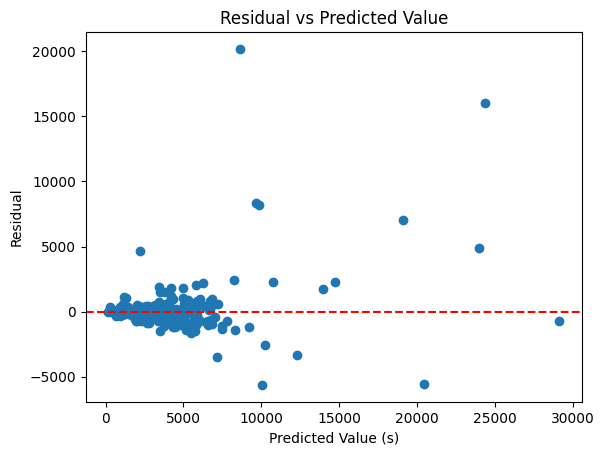

In [41]:
plt.scatter(y_pred, residuals_log)
plt.xlabel('Predicted Value log domain (log s)')
plt.ylabel('Residuals')
plt.title('Residuals in log domain')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Residual vs Predicted Plot
plt.scatter(np.exp(y_pred), residuals)
plt.xlabel('Predicted Value (s)')
plt.ylabel('Residual')
plt.title('Residual vs Predicted Value')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

### Interpretation of Residual Plots

We see that the model is being affected by some outliers, if we were to put this model into production though, we would likely not care about this assuming the goal was to build a model that would predict typical activities with the most accuaracy.


## Conclusion

### Impact
The findings of this study demonstrate the importance of choosing appropriate imputation methods for specific data types and missingness patterns. The comparison of different imputation techniques offers insights into their strengths and weaknesses.

### Future Work
Future research may explore additional imputation methods, refine the modeling techniques, or apply the insights to other domains. The methodology and findings of this study provide a foundation for further exploration and improvement in the field of data imputation.
